<a href="https://colab.research.google.com/github/lorek/MethodsClassDimRed/blob/main/MoCaDR_List_nr_5_auto_grad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GRADIENT METHODS. AUTOMATIC DIFFERENTIATION

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate
import torch
from torch.autograd import Variable
from sklearn.linear_model import LinearRegression
import time



In [ ]:
np.random.seed(0)

In [ ]:
 device = 'cuda' if torch.cuda.is_available() else 'cpu'
 print("device = ", device)

device =  cpu


# Linear Regression
## Data:
We are given $n$ points $(x_1,y_1), \ldots, (x_n,y_n)$.
Example: $n=200$:

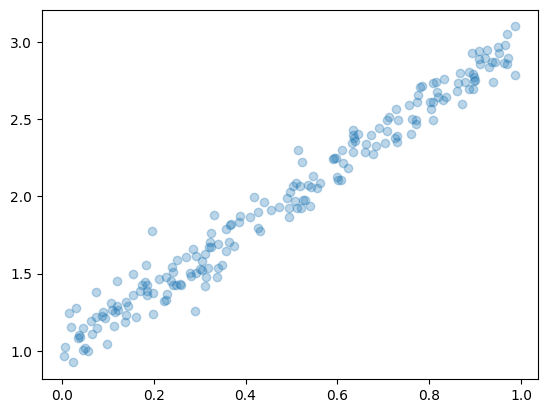

In [ ]:
nr_points=200
np.random.seed(42)
x_train = np.random.rand(nr_points, 1)

a_true=2;
b_true=1;
y_train = b_true + a_true * x_train + .1 * np.random.randn(nr_points, 1)



plt.scatter(x_train,y_train,alpha=0.3)

(in descriptioins we abbreviate `x_train` as $x$ and `y_train` as $y$)

Goal: We want to "predict" $y$ given $x$ via finding "best" line. To be more exact, given $x$ we predict $$\hat{y}=ax+b.$$ We want to  find $a, b$ such that
$$error = loss =  f(a,b)={1\over n}\sum_{i=1}^n (\hat{y}_i-y_i)^2 = {1\over n}\sum_{i=1}^n (a x_i + b-y_i)^2$$ is minimalized.

Let us have a look how $f(a,b)$ looks like

drawing $f$, non-Python (slow, two `for` loops) way:

(40, 40)
Running time:  0.0315556526184082  s


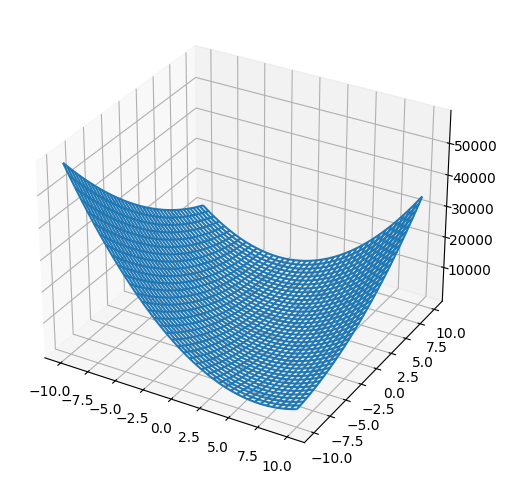

In [ ]:


aa = np.linspace(-10,10,40)
bb = np.linspace(-10,10,40)
aa2,bb2=np.meshgrid(aa,bb)
print(aa2.shape)

t_start = time.time()

ff2=np.zeros(aa2.shape)
for i in np.arange(aa2.shape[0]):
  for j in np.arange(aa2.shape[1]):
    ff2[i,j]=np.sum((aa[i]*x_train+bb[j]-y_train)**2)

t_end = time.time()

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.plot_wireframe(aa2,bb2,ff2)


print("Running time: ", t_end-t_start , " s")

drawing $f$,  Python   way:

Running time:  0.038729190826416016  s


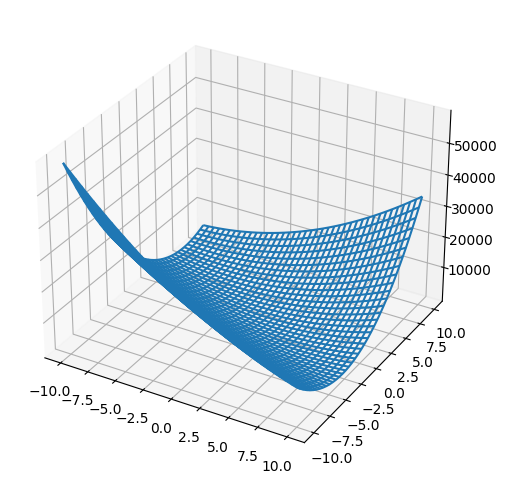

In [ ]:

t_start = time.time()

aa2_expanded = aa2[:, np.newaxis, :]  # New shape: (40, 1, 40)
bb2_expanded = bb2[:, np.newaxis, :]  # New shape: (40, 1, 40)

ff2 = np.sum((aa2_expanded * x_train + bb2_expanded - y_train) ** 2, axis=1)
t_end = time.time()

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.plot_wireframe(aa2,bb2,ff2)


print("Running time: ", t_end-t_start , " s")

# Gradient
In general, we may start with some $(a_0,b_0)$ and ($\rho$ -- learning rate)
$$(a_{t+1}, b_{t+1})  \leftarrow (a_t, b_t) - \rho \nabla f(a,b)|_{a=a_t, b=b_t}$$
In other words:
$$a_{t+1}  \leftarrow a_t - \rho{\partial \over \partial a} f(a,b)|_{a=a_t, b=b_t}$$
$\  $
$$b_{t+1}  \leftarrow b_t - \rho{\partial \over \partial b} f(a,b)|_{a=a_t, b=b_t}$$


## Computing partial derivatives <b>MANUALLY<b>
For this function  
$$ f(a,b)=(\hat{y}_i-y_i)^2 = {1\over n}\sum_{i=1}^n (a x_i + b-y_i)^2$$
$f$ we have
$${\partial\over\partial a} f(a,b)  = {1\over n}\sum_{i=1}^n 2(ax_i+b-y_i) x_i$$
$${\partial\over\partial b} f(a,b)  = {1\over n}\sum_{i=1}^n 2(ax_i+b-y_i) $$

## "Best solution" found -- using <tt>sklearn</tt> library (just to compare with our methods):

In [ ]:
linr = LinearRegression()
linr.fit(x_train, y_train)
a_skl = linr.coef_[0].item()
b_skl = linr.intercept_.item()

print("a_skl = ", a_skl, ", b_skl = ", b_skl)

a_skl =  1.9921928931825028 , b_skl =  1.0105201150960823


# Stochastic gradient, tterative updates ($\rho$ - learning rate):
$$a_{t+1}  \leftarrow a_t - \rho{\partial \over \partial a} f(a,b)|_{a=a_t, b=b_t},\qquad \qquad
b_{t+1}  \leftarrow b_t - \rho{\partial \over \partial b} f(a,b)|_{a=a_t, b=b_t}$$

Text(0.5, 1.0, 'Loss (every 10 epochs)')

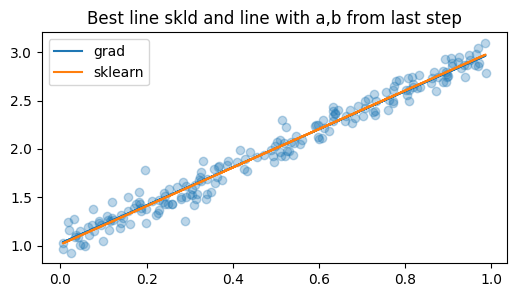

<Figure size 640x480 with 0 Axes>

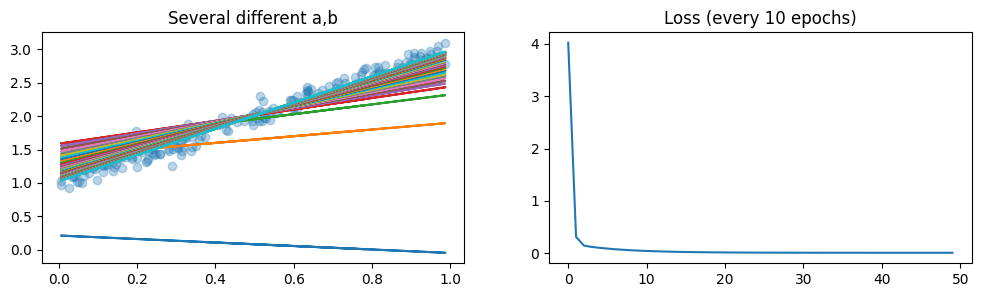

In [ ]:
lr = 0.06
n_epochs = 500

loss_list = []
a_list =[]
b_list =[]

# random inital a, b
np.random.seed(2)
a = np.random.normal(0,1)
b = np.random.normal(0,1)

# main iteration:
for epoch in range(n_epochs):
  grad_a = 2*np.mean((a*x_train+b-y_train)*x_train)    ## <- Again, we computed derivatives MANUALLY
  grad_b = 2*np.mean(a*x_train+b-y_train)

  a = a - lr*grad_a
  b = b - lr*grad_b

  #below is just for later figures:
  if ((epoch % 10)==0):
    a_list.append(a)
    b_list.append(b)
    loss = np.mean((a * x_train + b-y_train)**2)
    loss_list.append(loss.item())


plt.figure(figsize=(6,3))
plt.scatter(x_train,y_train,alpha=0.3)
plt.plot(x_train,a*x_train+b, label = "grad")
plt.plot(x_train ,a_skl*x_train +b_skl, label = "sklearn")
plt.title("Best line skld and line with a,b from last step")
plt.legend()

plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

axes[0].scatter(x_train,y_train,alpha=0.3)
axes[0].set_title("Several different a,b")
for i in np.arange(len(a_list)):

  aa=a_list[i]
  bb=b_list[i]
  axes[0].plot(x_train,aa*x_train+bb)

axes[1].plot(np.arange(len(loss_list)),loss_list)
axes[1].set_title("Loss (every 10 epochs)")

# Automatic differentation in torch

Again, mannually: $$  f(a,b)={1\over n}\sum_{i=1}^n (\hat{y}_i-y_i)^2 = {1\over n}\sum_{i=1}^n (a x_i + b-y_i)^2$$
$${\partial\over\partial a} f(a,b)  = {1\over n}\sum_{i=1}^n 2(ax_i+b-y_i) x_i$$
$${\partial\over\partial b} f(a,b)  = {1\over n}\sum_{i=1}^n 2(ax_i+b-y_i) $$

Compute *MANUALLY* values of gradients at `a=2.0` and `b=4.0`

In [ ]:
a=2.0
b=4.0

print("grad_a = ", 2*np.mean((a*x_train+b-y_train)*x_train))
print("grad_b = ",2*np.mean(a*x_train+b-y_train))

grad_a =  2.898862652293246
grad_b =  5.986517146534729


### a_tensor, b_tensor -- type "tensor", gradients will be computed:

In [ ]:
# type 'tensor', can comptute gradients
a_tensor = torch.tensor(2.0, requires_grad=True)
b_tensor = torch.tensor(4.0, requires_grad=True)
print("a_tensor = ", a_tensor,", b_tensor = ", b_tensor)

a_tensor =  tensor(2., requires_grad=True) , b_tensor =  tensor(4., requires_grad=True)


We also need

In [ ]:
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

Define  $loss$ (function $f$)

In [ ]:
yhat = a_tensor * x_train_tensor + b_tensor
error = y_train_tensor - yhat
loss = torch.mean((error ** 2))
# == loss = torch.mean(torch.pow(x_train_tensor*a_tensor+b_tensor-y_train_tensor,2))
loss.backward()

print("grad_a (torch) = ", a_tensor.grad)
print("grad_b (torch) = ", b_tensor.grad)

print()

grad_a (torch) =  tensor(2.8989)
grad_b (torch) =  tensor(5.9865)



Text(0.5, 1.0, 'Loss (every 10 epochs)')

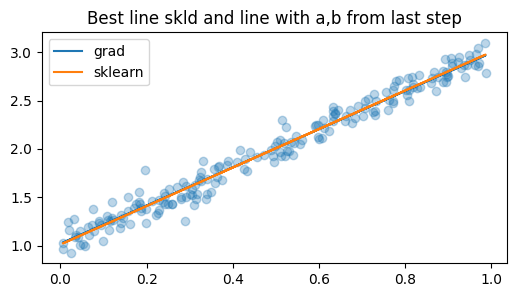

<Figure size 640x480 with 0 Axes>

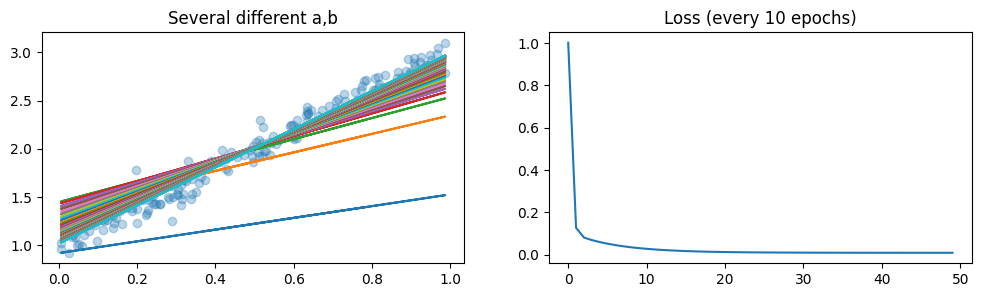

In [ ]:
lr = 0.06
n_epochs = 500

loss_list = []
a_list =[]
b_list =[]

# random inital a, b

a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)


optimizer = torch.optim.SGD([a, b], lr=lr) # Stochastic Gradiend Descent
# optimizer = torch.optim.Adam([a, b], lr=lr) # More sophisticated method


# main iteration:
for epoch in range(n_epochs):

  yhat = a  * x_train_tensor + b
  error = y_train_tensor - yhat
  loss = torch.mean((error ** 2))

  loss.backward()

  optimizer.step()
  optimizer.zero_grad()

  #below is just for later figures:
  if ((epoch % 10)==0):
    a_list.append(a.item())
    b_list.append(b.item())
    #loss = np.mean((a * x_train + b-y_train)**2)
    loss_list.append(loss.item())


plt.figure(figsize=(6,3))
plt.scatter(x_train,y_train,alpha=0.3)
plt.plot(x_train,a.item()*x_train+b.item(), label = "grad")
plt.plot(x_train ,a_skl*x_train +b_skl, label = "sklearn")
plt.title("Best line skld and line with a,b from last step")
plt.legend()

plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

axes[0].scatter(x_train,y_train,alpha=0.3)
axes[0].set_title("Several different a,b")
for i in np.arange(len(a_list)):

  aa=a_list[i]
  bb=b_list[i]
  axes[0].plot(x_train,aa*x_train+bb)

axes[1].plot(np.arange(len(loss_list)),loss_list)
axes[1].set_title("Loss (every 10 epochs)")

# Q5.1
* Sample `x_test`, a vector of size 50 of i.i.d $\mathcal{U}(0,1)$ random variables and similarly compute corresponding

$\qquad$ `y_test = b_true + a_true * x_test + .1 * np.random.randn(nr_points, 1)`

* Take the model (aka `a` and `b`) trained on `(x_train,y_train)` and compute final loss on test set, i.e.,
$$loss_{final} = {1\over n}\sum_{i=1}^{50} (a\cdot x\_{test} + b - y_{test})^2$$
* Using SGD or Adam find new $a$ and $b$ minimizing function
$$g(a,b)={1\over n}\sum_{i=1}^n (\hat{y}_i-y_i)^2 + \lambda(a^2+b^2)$$
with $\lambda=0.1$
* Can you also optimze  somehow  for `lambda>0`?

# Many more parameters to optimize.. e.g., **matrices**
Parameters we optimize do not have to be scalars, they can be vectors, matrices,...

Say we are given $\mathbf{Z}$ of size $n\times d$ and want to represent it as
$$\mathbf{Z}\approx \mathbf{W}\mathbf{H}$$
where $\mathbf{W}$ is of size $n\times r$ and $\mathbf{H}$ is of size $r\times d$

No restrictions on entries of $\mathbf{W}$ and $\mathbf{H}$, goal is to minimize some $dist(\mathbf{Z},\mathbf{W}\mathbf{H})$, e.g. Frob:
 $$dist_{Frob}(\mathbf{Z},\mathbf{W}\mathbf{H})=||\mathbf{Z}-\mathbf{W}\mathbf{H}||^2=\sum_{i,j} (\mathbf{Z}[i,j] -(\mathbf{W}\mathbf{H})[i,j])^2$$

In [ ]:
d=15
n=11
Z = torch.randint(0,10,(n,d))
print(Z)

tensor([[1, 3, 6, 6, 4, 6, 3, 4, 6, 2, 8, 6, 0, 6, 1],
        [0, 2, 8, 7, 8, 0, 0, 3, 7, 1, 6, 9, 1, 4, 3],
        [9, 9, 3, 3, 0, 9, 7, 2, 1, 0, 9, 8, 2, 0, 1],
        [4, 3, 2, 0, 6, 6, 1, 7, 8, 4, 4, 9, 1, 2, 1],
        [0, 2, 8, 0, 1, 6, 8, 6, 0, 3, 7, 4, 4, 5, 5],
        [4, 7, 5, 3, 2, 5, 2, 3, 6, 2, 7, 7, 8, 0, 3],
        [6, 9, 1, 0, 9, 7, 8, 5, 8, 6, 6, 4, 4, 9, 5],
        [0, 0, 1, 8, 7, 8, 7, 9, 8, 5, 7, 4, 1, 2, 4],
        [8, 6, 3, 5, 5, 4, 1, 8, 2, 5, 2, 3, 4, 6, 2],
        [3, 6, 2, 7, 3, 8, 7, 1, 0, 1, 8, 6, 0, 0, 9],
        [8, 0, 6, 3, 0, 6, 7, 1, 2, 1, 2, 2, 0, 2, 4]])


Set r, sample random matrices  $\mathbf{H}, \mathbf{W}$  (each entry  $\mathcal{N}$(0,1)  i.i.d)

In [ ]:
r=2
W = torch.randn((n,r), requires_grad=True, dtype=torch.float, device=device)
H = torch.randn((r,d), requires_grad=True, dtype=torch.float, device=device)
print(W,"\n",H)

tensor([[-1.5132, -0.9679],
        [ 0.1524, -0.7541],
        [ 0.1727,  1.6222],
        [ 1.3654, -0.3409],
        [-1.1413,  0.3922],
        [-0.9628,  0.4340],
        [-0.8007, -0.6847],
        [ 1.7693, -1.0444],
        [-0.1040,  0.3476],
        [-0.1188, -0.3681],
        [-1.1151, -1.8890]], requires_grad=True) 
 tensor([[ 0.6553, -0.8403,  0.0364, -1.2514, -0.7627, -1.2468,  0.6726, -0.9610,
         -0.2285,  1.4672,  1.4732, -0.4058, -0.3137, -0.3334, -1.1507],
        [-0.9099, -0.9157,  0.8229, -1.9865, -0.7595,  0.7416,  1.4495, -0.5644,
          0.0670, -0.3951,  0.0202,  0.2999,  0.3723, -0.3288,  1.7568]],
       requires_grad=True)


In [ ]:
loss=torch.sum(torch.pow(Z-torch.matmul(W,H),2))
print(loss)

tensor(4566.0825, grad_fn=<SumBackward0>)


Nr of parameters = n*r+r*d=

In [ ]:
print("Nr of parameters in Z : ", n*d)
print("Nr of parameters in H and W : ",n*r+r*d)
print("Fraction/reduction: ", np.round((n*r+r*d)/(n*d),4))

Nr of parameters in Z :  165
Nr of parameters in H and W :  52
Fraction/reduction:  0.3152


tensor(4.2607, grad_fn=<MeanBackward0>)
final loss2 =  4.260738372802734


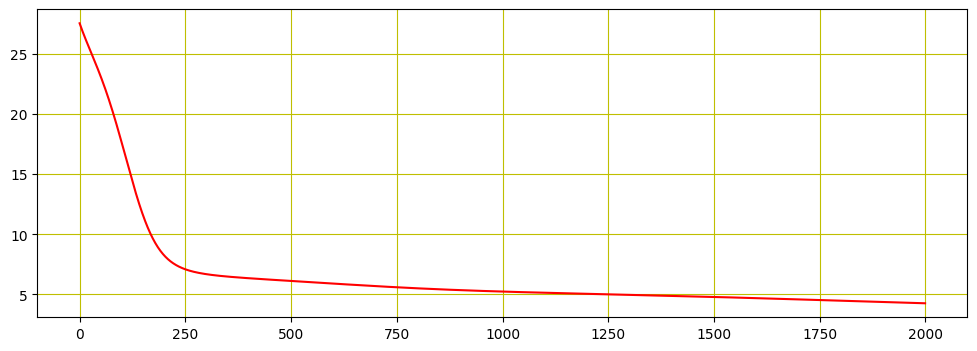

In [ ]:

lr = 0.02
n_epochs = 2000

r=3
W = torch.randn((n,r), requires_grad=True, dtype=torch.float, device=device)
H = torch.randn((r,d), requires_grad=True, dtype=torch.float, device=device)


optimizer = torch.optim.SGD([W, H], lr=lr)
#optimizer = torch.optim.Adam([W, H], lr=lr)

loss_list = []

for epoch in range(n_epochs):

    # just define loss! everything less automatic
    loss=torch.mean(torch.pow(Z-torch.matmul(W,H),2))   ## <- MAIN ONE


    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    loss_list.append(loss.item())

print(loss)


#fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,4))
plt.figure(figsize=(12,4))
plt.plot(loss_list, 'r')
plt.grid('True', color='y')


final_loss=loss.item()
print("final loss2 = ", loss.item())


In [ ]:
print("W = ", W, "\nH=",H)

W =  tensor([[ 1.2480, -1.0894, -1.9797],
        [ 1.0086, -0.0693, -1.8559],
        [ 2.9752,  0.4244, -0.3684],
        [ 0.6423,  0.7221, -2.2588],
        [ 1.1210, -2.1106, -1.8943],
        [ 1.6697,  0.7928, -1.3774],
        [ 1.2752,  0.9145, -2.7965],
        [ 1.5168, -1.7827, -2.1605],
        [ 1.0151,  1.4475, -1.7634],
        [ 3.4433, -0.7442,  0.2327],
        [ 1.4965, -1.0992, -0.7134]], requires_grad=True) 
H= tensor([[ 1.8419,  2.2138,  0.7991,  2.0159,  0.6691,  2.3804,  1.8929,  0.4473,
          0.3039,  0.2124,  2.4036,  2.0502,  0.4230, -0.0750,  1.8136],
        [ 1.6465,  1.9584, -0.8982, -0.4302,  0.7524, -0.5338, -1.3738, -0.0848,
          0.4291,  0.2477, -0.5784,  0.6200,  0.7975,  0.0921, -0.4663],
        [-0.7738, -0.8669, -1.5105, -0.3048, -2.1562, -1.3316, -0.9198, -2.4158,
         -2.6213, -1.6237, -1.3927, -1.5833, -1.1533, -2.2345, -0.3171]],
       requires_grad=True)


Recovered $\mathbf{Z}$:


In [ ]:
print("Recovered (rounded) Z, i.e., W*H = \n ",np.round(torch.matmul(W,H).detach().numpy(),2))
print("Original Z = \n ",np.round(Z.detach().numpy(),2))


Recovered (rounded) Z, i.e., W*H = 
  [[ 2.04  2.35  4.97  3.59  4.28  6.19  5.68  5.43  5.1   3.21  6.39  5.02
   1.94  4.23  3.4 ]
 [ 3.18  3.71  3.67  2.63  4.62  4.91  3.71  4.94  5.14  3.21  5.05  4.96
   2.51  4.07  2.45]
 [ 6.46  7.74  2.55  5.93  3.1   7.35  5.39  2.18  2.05  1.34  7.42  6.95
   2.02  0.64  5.31]
 [ 4.12  4.79  3.28  1.67  5.84  4.15  2.3   5.68  6.43  3.98  4.27  5.34
   3.45  5.07  1.54]
 [ 0.06 -0.01  5.65  3.75  3.25  6.32  6.76  5.26  4.4   2.79  6.55  3.99
   0.98  3.95  3.62]
 [ 5.45  6.44  2.7   3.44  4.68  5.39  3.34  4.01  4.46  2.79  5.47  6.1
   2.93  3.03  3.1 ]
 [ 6.02  7.04  4.42  3.03  7.57  6.27  3.73  7.25  8.11  5.04  6.43  7.61
   4.49  6.24  2.77]
 [ 1.53  1.74  6.08  4.48  4.33  7.44  7.31  6.05  5.36  3.39  7.69  5.43
   1.71  4.55  4.27]
 [ 5.62  6.61  2.17  1.96  5.57  3.99  1.55  4.59  5.55  3.44  4.06  5.77
   3.62  4.    1.73]
 [ 4.94  5.96  3.07  7.19  1.24  8.28  7.33  1.04  0.12  0.17  8.38  6.23
   0.59 -0.85  6.52]
 [ 1.5   1.78

# Q5.2
* Perform Truncated SVD, i.e., decompose $\mathbf{Z}=\mathbf{U}\mathbf{\Lambda}^{1\over 2} \mathbf{V}^T$, denote $\mathbf{W}=\mathbf{U}, \mathbf{H}=\mathbf{\Lambda}^{1\over 2} \mathbf{V}^T$. Then approximate $\mathbf{Z}$ by $\mathbf{Z}_r=\mathbf{W}_r \mathbf{H}_r$. Compare with SGD/Adam methods for various values of $r$. What are the conclusions?
* Consider different distance
 $$dist_{4}(\mathbf{Z},\mathbf{W}\mathbf{H})=\sum_{i,j} (\mathbf{Z}[i,j] -(\mathbf{W}\mathbf{H})[i,j])^4$$
 Find "best" matrices $\mathbf{W}, \mathbf{H}$ using SGD/Adam methods. Compare with distance computed for truncated SVD.


## Non-negative matrices Matrices  $\mathbf{W},\mathbf{H} $

Note that currently found matrices are NOT non-negative

In [ ]:
print(W,"\n",H)

tensor([[ 1.2480, -1.0894, -1.9797],
        [ 1.0086, -0.0693, -1.8559],
        [ 2.9752,  0.4244, -0.3684],
        [ 0.6423,  0.7221, -2.2588],
        [ 1.1210, -2.1106, -1.8943],
        [ 1.6697,  0.7928, -1.3774],
        [ 1.2752,  0.9145, -2.7965],
        [ 1.5168, -1.7827, -2.1605],
        [ 1.0151,  1.4475, -1.7634],
        [ 3.4433, -0.7442,  0.2327],
        [ 1.4965, -1.0992, -0.7134]], requires_grad=True) 
 tensor([[ 1.8419,  2.2138,  0.7991,  2.0159,  0.6691,  2.3804,  1.8929,  0.4473,
          0.3039,  0.2124,  2.4036,  2.0502,  0.4230, -0.0750,  1.8136],
        [ 1.6465,  1.9584, -0.8982, -0.4302,  0.7524, -0.5338, -1.3738, -0.0848,
          0.4291,  0.2477, -0.5784,  0.6200,  0.7975,  0.0921, -0.4663],
        [-0.7738, -0.8669, -1.5105, -0.3048, -2.1562, -1.3316, -0.9198, -2.4158,
         -2.6213, -1.6237, -1.3927, -1.5833, -1.1533, -2.2345, -0.3171]],
       requires_grad=True)


Simple "softmax" trick:

tensor(4.1974, grad_fn=<MeanBackward0>)
final_loss =  4.260738372802734
final_loss_nonneg =  4.197403907775879


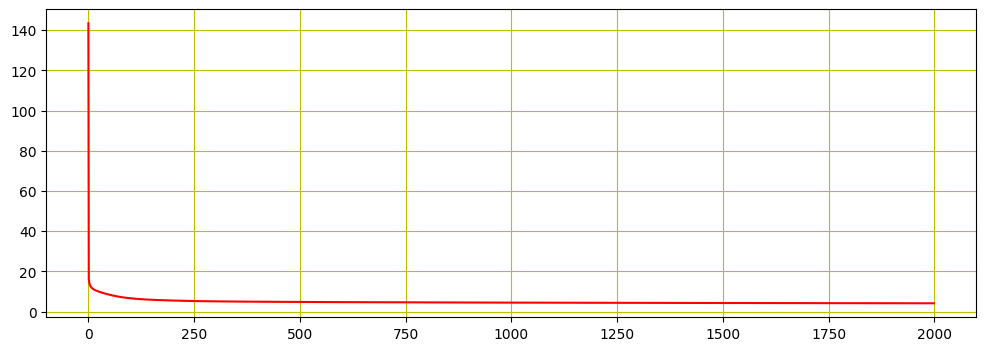

In [ ]:
lr = 0.02
n_epochs = 2000

r=3
W = torch.randn((n,r), requires_grad=True, dtype=torch.float, device=device)
H = torch.randn((r,d), requires_grad=True, dtype=torch.float, device=device)


optimizer = torch.optim.SGD([W, H], lr=lr)
#optimizer = torch.optim.Adam([W, H], lr=lr)

loss_list = []

for epoch in range(n_epochs):


    # loss=torch.mean(torch.pow(Z-torch.matmul(W,H),2))   ## <- OLD


    W2 = torch.exp(W)
    H2 = torch.exp(H)

    loss=torch.mean(torch.pow(Z-torch.matmul(W2,H2),2))


    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    loss_list.append(loss.item())

print(loss)


#fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,4))
plt.figure(figsize=(12,4))
plt.plot(loss_list, 'r')
plt.grid('True', color='y')


final_loss_nonneg=loss.item()
print("final_loss = ", final_loss)
print("final_loss_nonneg = ", final_loss_nonneg)

In [ ]:
# Final matrices:
W2 = torch.exp(W)
H2 = torch.exp(H)

In [ ]:
print(W2)
print(H2)


tensor([[2.1311, 0.5437, 1.0288],
        [3.5081, 0.1775, 0.2187],
        [0.3145, 1.4366, 1.9952],
        [1.8245, 1.8929, 0.0994],
        [0.5375, 0.5150, 1.9930],
        [1.6158, 1.3394, 0.7493],
        [0.5464, 4.2526, 0.4001],
        [0.4246, 1.3059, 2.0006],
        [0.3279, 3.2539, 0.1583],
        [0.1540, 0.3393, 2.7650],
        [0.1384, 0.8147, 1.4353]], grad_fn=<ExpBackward0>)
tensor([[0.2003, 0.5606, 2.0046, 1.3296, 1.6827, 0.3586, 0.1481, 0.9108, 2.1858,
         0.3647, 1.7208, 2.5719, 0.5254, 0.8641, 0.3445],
        [1.9414, 1.8353, 0.2105, 0.2315, 1.4410, 1.4445, 0.9370, 1.5853, 1.2630,
         1.3289, 0.7110, 0.7301, 0.9802, 1.4935, 0.5271],
        [0.5802, 0.9767, 1.3649, 1.8439, 0.4342, 2.9558, 2.9046, 0.9989, 0.3942,
         0.4520, 2.8221, 1.6264, 0.3127, 0.2584, 2.0230]],
       grad_fn=<ExpBackward0>)


# Q5.3
* Approximate the same  $\mathbf{Z}$ as
$$\mathbf{Z}\approx \mathbf{W}\mathbf{H}$$
where $\mathbf{W}$ is of size $n\times r$ and $\mathbf{H}$ is of size $r\times d$ (fix some $r<d$) so that
* a) $\mathbf{W}$ is a symmetric matrix
* b) $\mathbf{W}$ is a symmetric matrix with nonnegative entries
* c) $\mathbf{W}$ is symmetric and each entry of $\mathbf{H}$ is at least 0.5
